# GRUPO 6: TEXT TO SPEECH

## INTRODUCCIÓN

Nuestro proyecto trata sobre los sistemas Text To Speech, y nuestra intención es ofrecer una visión clara de cómo ha progresado esta tecnología a lo largo del tiempo, destacando los avances más novedosos relacionados con la síntesis neuronal, los distintos enfoques técnicos que han surgido, y las características que los diferencian entre sí.

Esta tecnología es súper importante en muchas áreas: desde ayudantes virtuales como Google Assistant o Siri, hasta programas que leen la pantalla para gente con problemas de visión, sin olvidar los GPS, las voces automatizadas que oímos al llamar a algún sitio, los juegos o la creación de videos y demás contenidos.

<img src="https://github.com/ManuelRic/Evolucion-TTS-Notebook/blob/main/img_intro.png?raw=1" style="width:550px; height:auto;" />

Además, nuestro objetivo no es solo ofreceros una explicación teórica, sino también facilitar una experiencia interactiva. En este cuaderno buscamos proporcionaros una información extra, donde se pueda ver como se maneja código y relacionarlo con ámbitos de la asignatura.

# Importante: Crea tu propia copia para guardar tus cambios

Este cuaderno se abre en **modo playground**, lo que significa que puedes ejecutar y modificar el contenido, pero:

- Los cambios que hagas **NO se guardarán en el archivo original**.
- Cada vez que abras el notebook desde este enlace, empezarás con la versión original, sin tus modificaciones previas.

Para trabajar de forma segura y guardar tu progreso, debes:  
**Ir al menú superior y hacer clic en:**  
**Archivo > Guardar una copia en Drive**

Esto creará **tu propia copia privada** en tu Google Drive donde podrás guardar todos tus cambios.

---

**Resumen:**  
- Estás trabajando en una versión temporal (playground).  
- Para conservar tus cambios, haz una copia en tu Drive.  
- No puedes modificar el archivo original con este enlace.

In [23]:
!pip install pyworld
!pip install gTTS
!pip install ipywidgets

In [24]:
import numpy as np
import pyworld as pw
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import librosa.display
import ipywidgets as widgets
from gtts import gTTS
from IPython.display import Audio, display
import os
from scipy import signal

## SÍNTESIS CONCATENATIVA

Aunque hoy en día nos suene normal que una máquina hable con nosotros, conseguirlo no fue nada fácil. La tecnología Text-to-Speech ha pasado por varias etapas hasta sonar tan natural como ahora.

Como ya hemos podido ver en la página web los sistemas concatenativos tienen muchas limitaciones pero son fáciles de mantener. A continuación puedes observar la version den python de synth-me en inglés.

Si te interesa solo hacerlo en español puedes visitar el apartado de nuestra página web "Síntesis Concatenativa" dónde también encontrarás un tutorial para hacerlo con tu propia voz.


In [25]:
# 1. Clonar el repositorio
!git clone https://github.com/stephengrice/synth-me.git

# 2. Ir al directorio principal
%cd synth-me

# 3. Añadir el subdirectorio al path de Python
import sys
sys.path.append('./synthme')

# 3. Importa la función desde el archivo tts.py
from tts import text_to_speech

Cloning into 'synth-me'...
remote: Enumerating objects: 208, done.
remote: Total 208 (delta 0), reused 0 (delta 0), pack-reused 208 (from 1)
Receiving objects: 100% (208/208), 7.58 MiB | 28.42 MiB/s, done.
Resolving deltas: 100% (82/82), done.
/content/synth-me/synth-me/synth-me


In [15]:
message = input("Message: ")

# Ejecuta la síntesis de voz
text_to_speech(message, debug=True, use_pronunciation_dict=True)

Audio('output.wav')

Message: hello
Text to Speech Generation started.
Words list: ['hello']
Phonemes list: [24, 3, 27, 8, 48]
File created.


## SÍNTESIS PARAMÉTRICA

Después llegaron los modelos matemáticos. En vez de usar grabaciones completas, estos sistemas tratan de simular la voz con fórmulas y estadísticas.

Como ya hemos comprobado en la web, la síntesis paramétrica es muy superior a la concatenativa. Por eso hemos querido que la puedas probar en ambos lugares, pero en este cuaderno queremos introduciros a los vocododres.

Este cuaderno te permite experimentar con la síntesis paramétrica utilizando un vocoder basado en el modelo WORLD, muy popular por su calidad y flexibilidad. El proceso que hemos seguido es típico en esta clase de síntesis:

1. Extracción de parámetros: A partir de la señal de voz original, se extraen tres componentes principales:

  - La frecuencia fundamental (F0), que representa el tono de la voz.

  - La envolvente espectral, que define el timbre.

  - Las componentes aperiódicas, que reflejan el ruido y las fricativas.

2. Síntesis: Estos parámetros se usan para reconstruir una versión de la voz original. Aunque no es una copia exacta, el resultado puede sonar muy natural si los parámetros están bien estimados.

In [16]:
from google.colab import files

uploaded = files.upload()

filename = next(iter(uploaded))

print(f"Archivo cargado: {filename}")

x, fs = librosa.load(filename, sr=16000)
x = x.astype(np.float64)

print(f"Audio cargado con fs = {fs}, duración = {len(x)/fs:.2f} segundos")

display(Audio(x, rate=fs))

Saving 5.wav to 5.wav
Archivo cargado: 5.wav
Audio cargado con fs = 16000, duración = 11.14 segundos


In [17]:
# F0/Pitch
_f0, t = pw.harvest(x, fs)

# Envolvente espectral
sp = pw.cheaptrick(x, _f0, t, fs)

# Componentes aperiódicas
ap = pw.d4c(x, _f0, t, fs)


In [18]:
# Síntesis a partir de los parámetros
y = pw.synthesize(_f0, sp, ap, fs)

display(Audio(y, rate=fs))

Además, hemos añadido una herramienta interactiva que te permite modificar la F0 (frecuencia fundamental) de forma dinámica. Esto se traduce en un cambio de tono, es decir, puedes hacer que la voz suene más grave o más aguda. A medida que mueves el deslizador:

- Se actualiza la curva de F0 en el gráfico superior.

- Se genera una nueva señal con el tono modificado.

- Se actualiza el espectrograma para que puedas visualizar cómo cambia el contenido frecuencial de la señal.

Te animamos a experimentar con diferentes valores de pitch y observar cómo cambia la señal sintetizada.<

In [19]:
def generar_espectrograma(audio, fs, title='Espectrograma', cmap='magma', y_axis='mel', figsize=(10, 4)):
    S = librosa.feature.melspectrogram(y=audio, sr=fs)
    S_db = librosa.power_to_db(S, ref=np.max)

    fig, ax = plt.subplots(figsize=figsize)

    img = librosa.display.specshow(S_db, sr=fs,
                                 x_axis='time',
                                 y_axis=y_axis,
                                 cmap=cmap,
                                 ax=ax)

    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set_title(title)
    plt.tight_layout()

    return fig, ax

In [20]:
def actualizar(pitch=1.0, show_original=True):
    f0_mod = _f0 * pitch
    y_mod = pw.synthesize(f0_mod, sp, ap, fs)
    display(Audio(y_mod, rate=fs))

    # Graficar curvas de F0
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    ax1.plot(t, _f0, label='F0 original', color='blue') if show_original else None
    ax1.plot(t, f0_mod, label=f'F0 x{pitch:.2f}', color='red', linestyle='--')
    ax1.set_title("Curvas de F0")
    ax1.set_xlabel("Tiempo (s)")
    ax1.set_ylabel("Frecuencia (Hz)")
    ax1.grid()
    ax1.legend()

    # Graficar espectrograma modificado
    S_mod = librosa.feature.melspectrogram(y=y_mod, sr=fs)
    S_db_mod = librosa.power_to_db(S_mod, ref=np.max)
    img_spec = librosa.display.specshow(S_db_mod, sr=fs, x_axis='time', y_axis='mel', ax=ax2, cmap='magma')
    fig.colorbar(img_spec, ax=ax2, format="%+2.0f dB")
    ax2.set_title(f"Espectrograma (Pitch x{pitch:.2f})")

    plt.tight_layout()
    plt.show()


pitch_slider = widgets.FloatSlider(
    value=1.0,
    min=0.1,
    max=2.0,
    step=0.1,
    description='Pitch:',
    continuous_update=False
)

ui = widgets.VBox([
    pitch_slider
])

out = widgets.interactive_output(
    actualizar,
    {'pitch': pitch_slider}
)

display(ui,out)

Output()

## SÍNTESIS NEURONAL

Hemos presenciado estos últimos años un avance increíble sobre la IA y sus capacidades, conduciendo a una nueva era a los sistemas de texto a voz. Usando inteligencia artificial, se entrenan modelos que aprenden cómo suena el habla humana de verdad. Ya no se pegan sonidos ni se simulan con fórmulas; ahora se genera la voz desde cero, una muestra de audio a la vez.

A continuación, hemos puesto a vuestra disposición un modelo basado en redes neuronales. En él podréis observar una diferencia tanto auditiva como en la generación de su espectrograma, así como la mejora con respecto a la síntesis paramétrica.

<img src="https://github.com/ManuelRic/Evolucion-TTS-Notebook/blob/main/evolution.png?raw=1" style="width:700px; height:200;" />



In [21]:
def text_to_speech_with_spectrogram(text, lang='es', slow=False, filename='output.mp3', show_spectrogram=True):
    tts = gTTS(text=text, lang=lang, slow=slow)

    temp_file = "gtts_temp.wav"
    tts.save(temp_file)

    display(Audio(temp_file, autoplay=False))

    if show_spectrogram:
        data, sample_rate = sf.read(temp_file)

        if len(data.shape) > 1:
            data = np.mean(data, axis=1)

        frequencies, times, spectrogram = signal.spectrogram(data, sample_rate, nperseg=512)
        plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram), shading='gouraud')
        plt.colorbar(label='Intensidad (dB)')
        plt.ylabel('Frecuencia (Hz)')
        plt.xlabel('Tiempo (s)')
        plt.title('Espectrograma del audio generado')
        plt.ylim(0, 8000)

    os.remove(temp_file)

<ipython-input-21-c1e556e7202f>:16: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram), shading='gouraud')


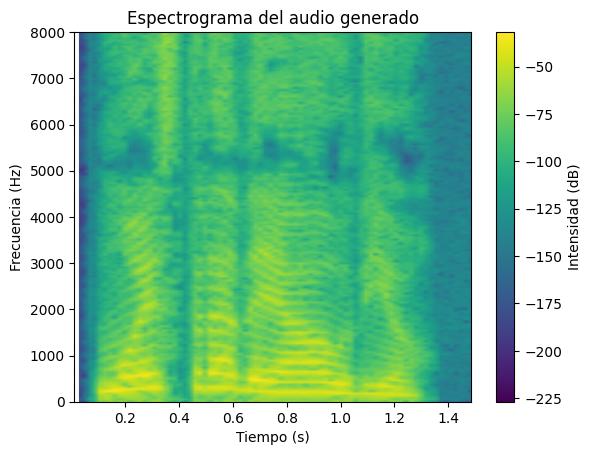

In [22]:
text_to_speech_with_spectrogram(
    text="Muestra de audio",
    lang='es',
    slow=False,
    show_spectrogram=True
)